In [1]:
import os
os.chdir(r"C:\Users\pauli\Documents\M2\fouille de données\projet\fichiers")


In [38]:
import random
import numpy as np
import pandas as pd
import time
from collections import Counter
from matplotlib import pyplot


from sklearn.model_selection import StratifiedKFold
#lib de metriques
from sklearn.metrics import precision_recall_curve, confusion_matrix, f1_score, make_scorer, auc



# recup les donnees pre process

In [7]:
Xtrain_smote = pd.read_csv('data_resample\Xtrain_smote.csv', sep=",")
ytrain_smote = pd.read_csv('data_resample\ytrain_smote.csv', sep=",")
ytrain_smote = ytrain_smote.squeeze()
print('SMOTE resampled dataset shape %s' % Counter(ytrain_smote))

Xtrain_SMOTETomek = pd.read_csv('data_resample\Xtrain_SMOTETomek.csv', sep=",")
ytrain_SMOTETomek = pd.read_csv('data_resample\ytrain_SMOTETomek.csv', sep=",")
ytrain_SMOTETomek = ytrain_SMOTETomek.squeeze()
print('SMOTE Tomeklinks resampled dataset shape %s' % Counter(ytrain_SMOTETomek))


SMOTE resampled dataset shape Counter({0: 91457, 1: 45728})
SMOTE Tomeklinks resampled dataset shape Counter({0: 3047115, 1: 3047115})


In [8]:
df = pd.read_csv('df_clean.csv', sep=",")
y = df.loc[:,"FlagImpaye"]
# Drop the 'FlagImpaye' column
X = df.drop(['month','day_name','FlagImpaye'], axis=1)
index_test = pd.read_csv('index_test.csv',sep=",")
index_test = index_test["0"].values.tolist()
#ytest
ytest = y.loc[index_test,]
#Xtest
Xtest = X.loc[index_test,]

In [14]:
index_train = Xtrain_SMOTETomek.index.to_list()
print(len(index_train))
random_index = random.sample(index_train, round(len(index_train)*0.03))
print(len(random_index))

6094230
182827


In [16]:
ytrain_SMOTETomek_random = ytrain_SMOTETomek.loc[random_index,]
#Xtest
Xtrain_SMOTETomek_random = Xtrain_SMOTETomek.loc[random_index,]

In [27]:
ytest.reset_index(drop=True, inplace=True)
Xtest.reset_index(drop=True, inplace=True)
ytrain = ytrain_smote.reset_index(drop=True)
Xtrain = Xtrain_smote.reset_index(drop=True)


## Boucle de recherche sur meilleur modele avec les meilleurs hyperparametres

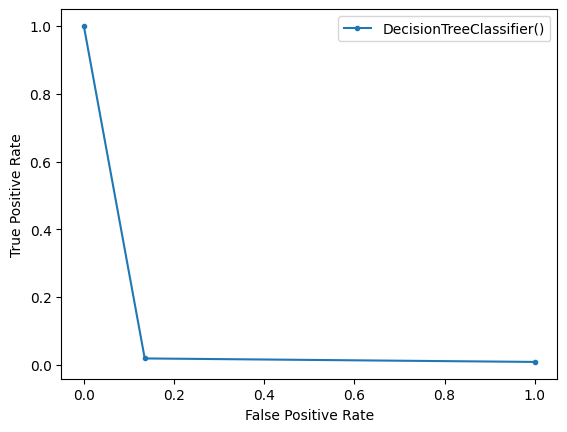

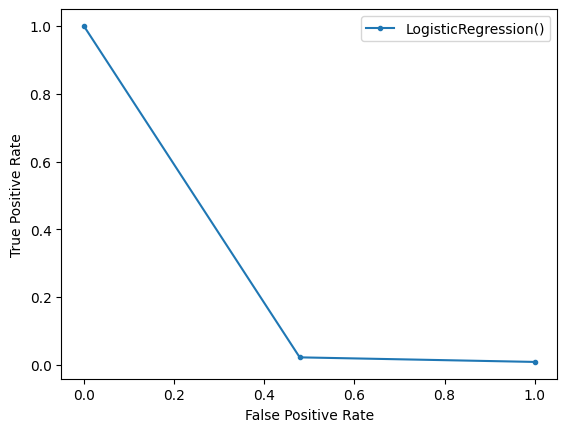

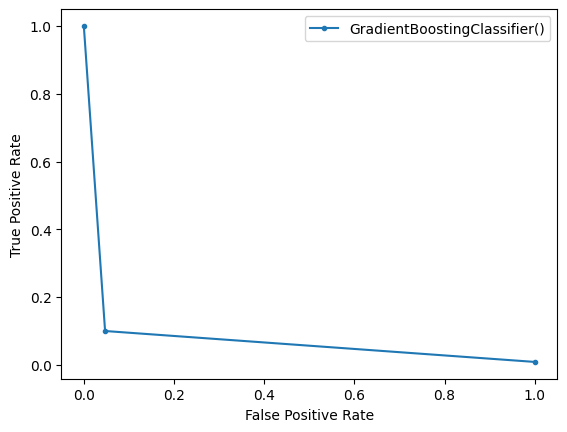

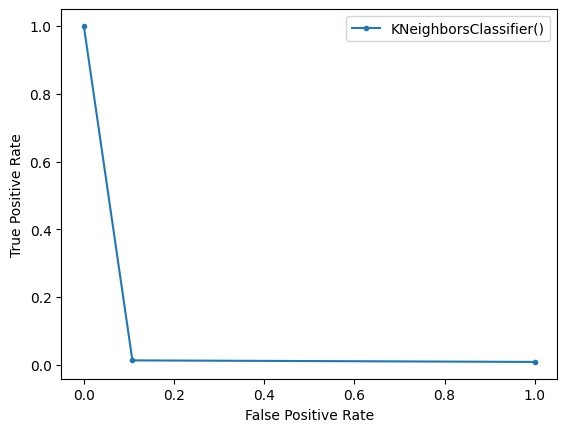

In [48]:
import warnings
warnings.filterwarnings("ignore")

import mlflow
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Fouilles de Données Massives")

seed = 1

# On stocke ci-dessous les valeurs des hyper-paramètres que l'on souhaite tester
#np.arange(start = 5, stop = 250, step = 50)
params_modeles = [
{'criterion':['log_loss'], 
 'max_features':['log2']},
{"solver":["newton-cg"],
 "penalty":["none"],
 "max_iter":[10, 50, 300, 50000]},
{"loss":["log_loss"],
 "learning_rate":[0.1, 0.01, 0.3],
 "n_estimators":[1000, 100, 10],
 "min_samples_split":[2, 30]},
{"n_neighbors":[2, 1, 5, 10],
 "algorithm":['ball_tree']}
]

from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
modeles_list = [
    DecisionTreeClassifier(),
    LogisticRegression(),
    GradientBoostingClassifier(),
    KNeighborsClassifier()
]

np.random.seed(seed)
random.seed(seed)


def select_model(modeles, parameters, Xtrain, ytrain, Xtest, ytest) :
    df = pd.DataFrame(columns = ['best','score', 'ftest', 'ftrain','rappel', 'precision', 'lr_auc', 'lr_precision', 'lr_recall', 'time_train'])    
    
    for i, modele in enumerate(modeles):
        modele_name = str(modele)
        
        #start run mlflow
        my_run = mlflow.start_run(run_name = modele_name)
        
        f1 = make_scorer(f1_score , average='macro')
        #test all models with CV
        from sklearn.model_selection import GridSearchCV
        model = GridSearchCV(estimator=modele,
                            param_grid=parameters[i],
                            scoring = f1,
                            verbose = False,
                            cv = 3)
        start_time = time.time()
        model.fit(Xtrain, ytrain)
        full_time = time.time() - start_time
        
        rankTrain = model.predict(Xtrain)
        rankTest = model.predict(Xtest)

        #calcul metrics
        #calcul de la f-mesure pour mesurer la performance du modele 
        ctrain = confusion_matrix(ytrain, rankTrain)
        rappel = round(ctrain[1,1]/(ctrain[1,1]+ctrain[1,0]),4)
        precision = round(ctrain[1,1]/(ctrain[1,1]+ctrain[0,1]),4)
        ftrain = round(2*ctrain[1,1]/(2*ctrain[1,1]+ctrain[0,1]+ctrain[1,0]),4)
        ctest = confusion_matrix(ytest, rankTest)
        ftest = round(2*ctest[1,1]/(2*ctest[1,1]+ctest[0,1]+ctest[1,0]),4)
        #calcul de l-AUC Precision-Rappel
        lr_precision, lr_recall, _ = precision_recall_curve(ytest, rankTest)
        lr_auc =  auc(lr_recall, lr_precision)
        pyplot.plot(lr_recall, lr_precision, marker='.', label=modele_name)
        # axis labels
        pyplot.xlabel('False Positive Rate')
        pyplot.ylabel('True Positive Rate')
        # show the legend
        pyplot.legend()
        # show the plot
        pyplot.show()
        
        #df with all indicators
        df.loc[i]=[model.best_estimator_, model.best_score_, ftest, ftrain, rappel, precision, lr_auc, lr_precision, lr_recall, full_time]
        
        #save info i mlflow
        mlflow.sklearn.log_model(modele,modele_name)
        #artifact
        #mlflow.log_artifact("guillaume.txt")
        #stocker les métriques
        my_run.metrics = {}
        #rajout des éléments de performance
        my_run.metrics['best'] = model.best_score_
        my_run.metrics['ftest'] = ftest
        my_run.metrics['ftrain'] = ftrain
        my_run.metrics['precision'] = precision
        my_run.metrics['rappel'] = rappel
        my_run.metrics['lr_auc']= lr_auc
        my_run.metrics['full_time']=full_time
        mlflow.log_metrics(my_run.metrics)
        #paramètres de l'algo
        mlflow.log_params(modele.get_params())
        mlflow.end_run()
        
    #return df with all indicators  
    return df

df_ind = select_model(modeles_list, params_modeles, Xtrain, ytrain, Xtest, ytest)


In [ ]:
mlflow.experiment("Fouilles de Données Massives")

In [50]:
df_ind

,best,score,ftest,ftrain,rappel,precision,lr_auc,lr_precision,lr_recall,time_train
0,"DecisionTreeClassifier(criterion='log_loss', m...",0.958902,0.0334,1.0000,1.0000,1.0000,0.080887,"[0.008794358124244893, 0.01906888850712936, 1.0]","[1.0, 0.13509812870835236, 0.0]",2.688534
1,"LogisticRegression(max_iter=300, penalty='none...",0.727440,0.0426,0.6127,0.5326,0.7212,0.252818,"[0.008794358124244893, 0.02227459973669682, 1.0]","[1.0, 0.478776814240073, 0.0]",182.387615
2,([DecisionTreeRegressor(criterion='friedman_ms...,0.993340,0.0641,0.9976,0.9955,0.9997,0.077771,"[0.008794358124244893, 0.1, 1.0]","[1.0, 0.047162635022059946, 0.0]",16224.868149
3,"KNeighborsClassifier(algorithm='ball_tree', n_...",0.947734,0.0238,1.0000,1.0000,1.0000,0.064455,"[0.008794358124244893, 0.013348919642520458, 1.0]","[1.0, 0.10771337288909173, 0.0]",355.144967


In [ ]:
#appliquer et sauvegarder le meilleur modele
#get index of df wich have best f1 score
indice=df_ind['ftest'].idxmax()
#keep model with best f score
best_model = df_ind["best"][indice]
best_model.fit(X, y)
pickle.dump(best_model, open("./model.pickle.dat", "wb"))


In [ ]:
#XGBoost/ gradient tree boosting 
from sklearn.ensemble import GradientBoostingClassifier 
param = {"loss":["log_loss"],"learning_rate":[0.1],"n_estimators":[100],"min_samples_split":[2]}
gbc = GradientBoostingClassifier()

#Nearest-Neighbor
from sklearn.neighbors import KNeighborsClassifier
param = {"n_neighbors":[2],"algorithm":['ball_tree']}
knc = KNeighborsClassifier()

#Decision Trees
from sklearn.tree import DecisionTreeClassifier
param = {"criterion":"gini","max_depth":None,"min_samples_split":2,"min_samples_leaf":1,"max_features":"sqrt"}
dtc = DecisionTreeClassifier()
dtc = dtc.fit(Xtrain, ytrain)

#Random Forests
from sklearn.ensemble import RandomForestClassifier
param = {"n_estimators":100,"criterion":"gini","max_depth":None,"min_samples_split":2,"min_samples_leaf":1,"max_features":"sqrt","oob_score":False,"warm_start":False,"max_samples":None}
rfc = RandomForestClassifier()
rfc = rfc.fit(Xtrain, ytrain)

#SVM
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
param = {"kernel":"rbf","degree":3,}
#ici on peut changer le noyaux
svc = make_pipeline(StandardScaler(), SVC(kernel="rbf",degree=3))
svc.fit(Xtrain, ytrain)

#K-means
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto")
kmeans.fit(Xtrain)
#bof ca, on ne prend meme pas en compte les y...


#LOF
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=2)
lof.fit(Xtrain)

#Auto-encodeurs
#keskecé ???

#Reseaux de neurones
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier(random_state=1, max_iter=100)
mlpc.fit(Xtrain, ytrain)

#ADL
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
adl = LinearDiscriminantAnalysis()
adl.fit(Xtrain, ytrain)

#ADQ
from sklearn.qda import QDA
qda = QDA()
qda.fit(Xtrain, ytrain)

#Cost-sensitive learning
#On pondère les erreurs 
#Modifier le poids de chaque classe sur le substitue de taux d’erreur 
#Attribuer un poids a chaque entrée de la matrice de confusion (cout a l’échelle de chaque classe) 

#Methodes ensemblistes
#bagging
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
param = {"max_features":0.5,"max_samples" : 0.5}
bagging = BaggingClassifier(KNeighborsClassifier())

#boosting 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
adab = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(adab, Xtrain, ytrain, cv=5)

#regression logistique
from sklearn.linear_model import LogisticRegression
param = {"solver":"saga","penalty":"none","max_iter":100}
logit = LogisticRegression(solver="saga", penalty="none", max_iter=100, random_state=1)
logit.fit(Xtrain, ytrain)





# afficher les modeles 

In [ ]:
#lancer les runs si on veut faire une seule boucle
for modele in liste:
    #le run
    therun = mlflow.start_run(run_name = modele[0])    
    #entraînement du modèle
    themodele = modele[1].fit(XTrain,yTrain)
    #prédiction
    predmodele = themodele.predict(XTest)
    #récupérer les résultats
    therun.metrics = {}
    therun.metrics['Accuracy'] = metrics.accuracy_score(yTest,predmodele)
    therun.metrics['Rappel'] = metrics.recall_score(yTest,predmodele,pos_label='good')
    therun.metrics['Precision'] = metrics.precision_score(yTest,predmodele,pos_label='good')
    #rajouter le modèle dans le log
    mlflow.sklearn.log_model(themodele,modele[0])
    #info sur les donnees
    mlflow.log_artifact("working_conditions.xlsx")
    #stocker les métriques
    mlflow.log_metrics(therun.metrics)
    #paramètres de l'algo
    mlflow.log_params(themodele.get_params())
    #finaliser
    mlflow.end_run()